In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
%matplotlib inline

In [3]:
dataset = pd.read_csv(dataset_path+'processed/cleanDatasetWithEncoding.csv')

In [4]:
# Reducing majority class by half
import random
random.seed(10)
drop_indices = np.random.choice( dataset[dataset['Label']==14].index, 1135521, replace=False)
dataset.drop(drop_indices,inplace=True)
print(dataset.groupby('Label').agg({'Label':'count'}).rename_axis(None).sort_values('Label', ascending=False))

      Label
14  1135500
3    230122
9    158804
1    128025
2     10293
6      7935
10     5897
5      5796
4      5499
0      1956
11     1507
13      652
8        36
12       21
7        11


In [5]:
del drop_indices

## Train Test Split

In [6]:
features = dataset.loc[:, dataset.columns != 'Label'].astype('float64')
labels = dataset['Label']
features.head()

,SourcePort,DestinationPort,Protocol,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,...,act_data_pkt_fwd,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin
3,49454.0,389.0,6.0,15206.0,17.0,12.0,3452.0,6660.0,1313.0,0.0,...,10.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,46126.0,88.0,6.0,1092.0,9.0,6.0,3150.0,3152.0,1575.0,0.0,...,2.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,37380.0,80.0,6.0,579225.0,132.0,150.0,160.0,320799.0,160.0,0.0,...,1.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,49413.0,49666.0,6.0,3.0,2.0,0.0,12.0,0.0,6.0,6.0,...,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,49666.0,49413.0,6.0,4.0,3.0,0.0,18.0,0.0,6.0,6.0,...,2.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
from sklearn.model_selection import train_test_split

In [8]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=.2, random_state=1)
features_train, features_val, labels_train, labels_val = train_test_split(features_train, labels_train, test_size=.25, random_state=1)

# SMOTE Up Sampling

In [9]:
class_dist = dict(labels_train.value_counts())
min = class_dist[7]
max_ten_perct = math.floor(class_dist[14]*0.1)
min_diff = max_ten_perct - min
for key in class_dist:
  if class_dist[key] < max_ten_perct:
    class_dist[key] = class_dist[key] + min_diff
print(class_dist)

{14: 681942, 3: 137615, 9: 95116, 1: 76831, 2: 74346, 6: 72947, 10: 71669, 5: 71634, 4: 71471, 0: 69413, 11: 69110, 13: 68591, 8: 68204, 12: 68195, 7: 68194}


In [10]:
from imblearn.over_sampling import SMOTE

# Using strategy
'''
We are making sure that the minority class is atleast 10% of the majority class.
So,
1. We calculate the 10% of the majority class.
2. Then, find how less is the minority class from the 10% of the majority class
3. Then, added the value from above step to all the classes which are less than 10 of the majority class

Here, as our dataset is quite large we tried to reduce the majority class by 50% and then do the above steps.
'''

smote = SMOTE(random_state=42, sampling_strategy=class_dist,n_jobs=-1)
features_train, labels_train = smote.fit_resample(features_train, labels_train)

## Standardization

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_val_scaled =  scaler.fit_transform(features_val)
features_test_scaled = scaler.fit_transform(features_test)

## Choosing a K value

In [12]:
from sklearn.neighbors import KNeighborsClassifier

In [13]:
error_rate = []

# Will take some time
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(features_train_scaled, labels_train)
    pred_i = knn.predict(features_val_scaled)
    error_rate.append(np.mean(pred_i != labels_va))

Text(0, 0.5, 'Error Rate')

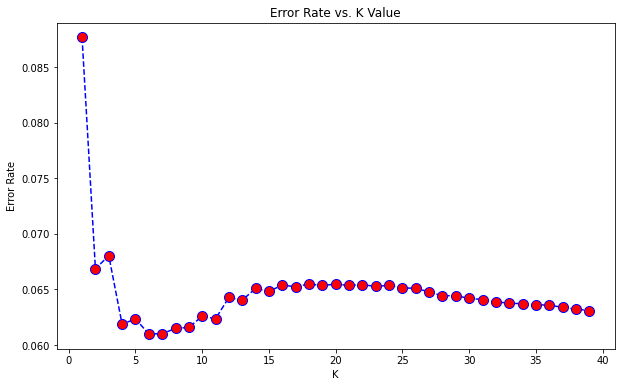

In [14]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [15]:
print(error_rate)

[0.08767150003989232, 0.06685952879782277, 0.06804447845962454, 0.06187446625552952, 0.062353174098950685, 0.06099683520925738, 0.06102047510275966, 0.06149918294618083, 0.061584877560126594, 0.06259548300734905, 0.06236794903238961, 0.06428278040607427, 0.0640404714976759, 0.06509540174521514, 0.06483831790337785, 0.06539090041399363, 0.06524906105297995, 0.06549136996137832, 0.06536135054711578, 0.06547955001462719, 0.06536135054711578, 0.06543522521431042, 0.06527270094648224, 0.06537317049386693, 0.06514268153221969, 0.0651042667052785, 0.06477921816962215, 0.06443052974046352, 0.06444234968721466, 0.06419413080544072, 0.06409661624474382, 0.06388976717659887, 0.0637656577357119, 0.06371837794870734, 0.0636090434412593, 0.06360608845457151, 0.06337855447961208, 0.06323080514522282, 0.06310078573096028]
